In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
from torchvision.transforms.transforms import RandomRotation
data_dir = './drive/MyDrive/Dataset'


stats = ([0.2, 0.2, 0.2], [0.229, 0.224, 0.225])

tfms_train = tt.Compose([transforms.Resize((64,64)),
                         #tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.RandomRotation(10),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)
                        ])

tfms_valid = tt.Compose([transforms.Resize((64,64)),tt.ToTensor(), tt.Normalize(*stats)])


train_set = ImageFolder(data_dir + '/training',tfms_train)
val_set = ImageFolder(data_dir + '/validation',tfms_valid)
test_set = ImageFolder(data_dir + '/testing',tfms_valid)


In [109]:
img,label = train_set[20]
print(img.shape,label)

torch.Size([3, 64, 64]) 0


In [100]:
def show_example(img, label):
    print('Label: ', train_set.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  n0 (0)
1097


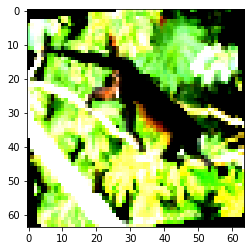

In [113]:
show_example(*train_set[26])
print(len(train_set))

In [79]:
batch_size = 10

In [110]:
train_dl = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_set, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_set, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [63]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9363bb0ef0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
A

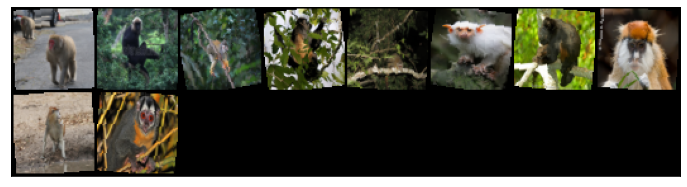

In [114]:
# USE THIS FOR THE RESNET STUFF
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
show_batch(train_dl)

# MODEL



In [66]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super(ResidualBlock,self).__init__()
        self.cnn1 =nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
        self.cnn2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()
            
    def forward(self,x):
        residual = x
        x = self.cnn1(x)
        x = self.cnn2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(True)(x)
        return x

In [ ]:
class MonkeyClassificationModelFF(nn.Module):
    def __init__(self):
        super().__init__()
        #self.linear = nn.Linear(64*64*3, 10)

        self.linear1 = nn.Linear(64*64*3, 2048)
        self.linear2 = nn.Linear(2048, 1096)
        self.linear3 = nn.Linear(1096, 10)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 64*64*3) # reshape into vector
        #out = self.linear(xb)
        out = self.linear1(xb)
        out = self.linear2(out)
        out = self.linear3(out)
        


        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MonkeyClassificationModelFF()
list(model.parameters())

[Parameter containing:
 tensor([[ 7.5952e-03, -4.1018e-03, -6.1023e-03,  ...,  3.7061e-03,
           7.2810e-03, -3.1565e-03],
         [-3.3006e-03, -3.2984e-03,  1.8692e-03,  ..., -1.2347e-03,
           8.1784e-05,  6.5904e-03],
         [-8.1670e-03,  1.4738e-03, -5.9085e-03,  ...,  7.7913e-03,
          -1.8938e-03,  2.1948e-03],
         ...,
         [ 3.0542e-03, -3.5441e-03,  1.6517e-03,  ..., -6.2360e-03,
           4.4435e-03,  8.4866e-03],
         [-3.7753e-03,  8.5614e-03,  5.5132e-03,  ..., -4.9388e-03,
           8.5068e-03, -1.2545e-04],
         [ 7.9275e-03,  6.6039e-03,  3.0621e-03,  ...,  3.4169e-03,
          -8.3728e-03,  1.5905e-03]], requires_grad=True),
 Parameter containing:
 tensor([ 3.7512e-05,  2.2590e-04,  7.7928e-04,  ...,  1.1523e-03,
          5.2839e-03, -7.6684e-03], requires_grad=True),
 Parameter containing:
 tensor([[ 6.1968e-03, -2.0880e-02,  1.2242e-02,  ...,  7.2762e-04,
          -9.9652e-03,  2.0916e-02],
         [-1.7765e-02, -1.2067e-02, 

In [67]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [82]:
device = get_default_device()
device

device(type='cuda')

In [83]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
#to_device(model, device); # for model 1

# **Training**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.09285714477300644, 'val_loss': 2.303339958190918}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history1 = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
history2 = fit(num_epochs, lr/10, model, train_dl, val_dl, opt_func)
history3 = fit(num_epochs, lr/100, model, train_dl, val_dl, opt_func)
history4 = fit(num_epochs, lr/1000, model, train_dl, val_dl, opt_func)

history = history1 + history2 + history3 + history4

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], val_loss: 2.6534, val_acc: 0.2655
Epoch [1], val_loss: 2.0484, val_acc: 0.3190
Epoch [2], val_loss: 2.0101, val_acc: 0.3774
Epoch [3], val_loss: 2.2074, val_acc: 0.3071
Epoch [4], val_loss: 2.6879, val_acc: 0.3417
Epoch [5], val_loss: 14.6373, val_acc: 0.1714
Epoch [6], val_loss: 29.2128, val_acc: 0.2357
Epoch [7], val_loss: 2.5689, val_acc: 0.3762
Epoch [8], val_loss: 2.4213, val_acc: 0.4071
Epoch [9], val_loss: 2.0830, val_acc: 0.4464
Epoch [0], val_loss: 1.7759, val_acc: 0.5190
Epoch [1], val_loss: 1.8201, val_acc: 0.5071
Epoch [2], val_loss: 1.8878, val_acc: 0.5250
Epoch [3], val_loss: 2.0220, val_acc: 0.5262
Epoch [4], val_loss: 2.0697, val_acc: 0.5286
Epoch [5], val_loss: 2.1075, val_acc: 0.5500
Epoch [6], val_loss: 2.3804, val_acc: 0.4881
Epoch [7], val_loss: 2.4615, val_acc: 0.5571
Epoch [8], val_loss: 2.2948, val_acc: 0.5179
Epoch [9], val_loss: 2.3436, val_acc: 0.5190
Epoch [0], val_loss: 2.2351, val_acc: 0.5631
Epoch [1], val_loss: 2.3295, val_acc: 0.5512
Epoch [2

In [ ]:
def predict_image(input_img, model):
    inputs = to_device(input_img.unsqueeze(0),device)
    predictions = model(inputs)
    _, preds  = torch.max(predictions, dim=1)
    return preds[0].item()

Label: n3 , Predicted: 3


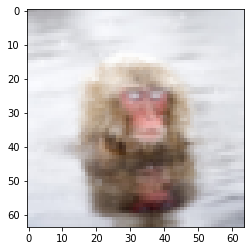

In [ ]:
img, label = val_set[90]
plt.imshow(img.permute(1, 2, 0))
print('Label:', val_set.classes[label], ', Predicted:', predict_image(img, model))

# CNN Model


In [ ]:
class MonkeyClassifierModelCNN(ImageClassificationBase):

  def __init__(self):
    super().__init__()
    
    
    self.network = nn.Sequential(
            # input: 3 x 64 x 64
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # output: 32 x 32 x 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # output: 64 x 32 x 32
            nn.ReLU(),
            # output: 64 x 32 x 32
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
  
  def forward(self, xb):
    return self.network(xb)


model = MonkeyClassifierModelCNN()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.09642856568098068, 'val_loss': 2.3031797409057617}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 0.4758, val_loss: 2.0111, val_acc: 0.5524
Epoch [1], train_loss: 0.3915, val_loss: 2.3236, val_acc: 0.5250
Epoch [2], train_loss: 0.3348, val_loss: 2.8680, val_acc: 0.5583
Epoch [3], train_loss: 0.2614, val_loss: 2.7497, val_acc: 0.5595
Epoch [4], train_loss: 0.2756, val_loss: 2.2890, val_acc: 0.5202
Epoch [5], train_loss: 0.1247, val_loss: 2.6974, val_acc: 0.5845
Epoch [6], train_loss: 0.1519, val_loss: 3.2851, val_acc: 0.5357
Epoch [7], train_loss: 0.1496, val_loss: 2.8699, val_acc: 0.5464
Epoch [8], train_loss: 0.0742, val_loss: 3.2352, val_acc: 0.5750
Epoch [9], train_loss: 0.1192, val_loss: 2.9675, val_acc: 0.5631


RES-NET APPROACH


In [89]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 128)    # 3 x 64 x 64 -> 128 x 64 x 64
        self.conv2 = conv_block(128, 256, pool=True) # 128 x 64 x 64 -> 256 x 32 x 32
        self.res1 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        
        self.conv3 = conv_block(256, 512, pool=True) # 256 x 32 x 32 -> 512 x 16 x 16
        self.conv4 = conv_block(512, 1024, pool=True) # 512 x 16 x 16 -> 1024 x 8 x 8
        self.res2 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4),   # 1024 x 2 x 2
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(1024 * 2 * 2, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [90]:
model3 = to_device(ResNet9(3, 10), device)
model3

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace

In [91]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [92]:
history = [evaluate(model3, val_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.06071428582072258, 'val_loss': 2.3070714473724365}]

In [97]:
epochs = 20
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [98]:
history += fit_one_cycle(epochs, max_lr, model3, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: 1.0271, val_loss: 1.3449, val_acc: 0.5988
Epoch [1], train_loss: 1.3996, val_loss: 3.2923, val_acc: 0.4774
Epoch [2], train_loss: 1.9649, val_loss: 1.2583, val_acc: 0.5631
Epoch [3], train_loss: 2.2285, val_loss: 2.1897, val_acc: 0.4619
Epoch [4], train_loss: 1.7124, val_loss: 2.2545, val_acc: 0.4024
Epoch [5], train_loss: 1.6934, val_loss: 9.6182, val_acc: 0.2762
Epoch [6], train_loss: 1.4721, val_loss: 2.2319, val_acc: 0.4286
Epoch [7], train_loss: 1.3487, val_loss: 1.8105, val_acc: 0.4464
Epoch [8], train_loss: 1.2422, val_loss: 1.6401, val_acc: 0.4702
Epoch [9], train_loss: 1.1852, val_loss: 1.0409, val_acc: 0.6393
Epoch [10], train_loss: 1.0954, val_loss: 0.9400, val_acc: 0.6881
Epoch [11], train_loss: 1.0194, val_loss: 1.1264, val_acc: 0.6107
Epoch [12], train_loss: 0.8892, val_loss: 4.1019, val_acc: 0.4571
Epoch [13], train_loss: 0.7982, val_loss: 0.9556, val_acc: 0.6857
Epoch [14], train_loss: 0.6663, val_loss: 0.6969, val_acc: 0.7405
Epoch [15], train_lo

In [105]:
def predict_image(input_img, model):
    inputs = to_device(input_img.unsqueeze(0),device)
    predictions = model(inputs)
    _, preds  = torch.max(predictions, dim=1)
    return preds[0].item()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: n1 , Predicted: n1


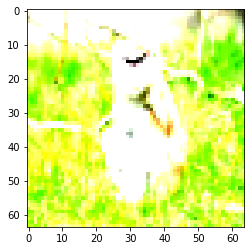

In [111]:
img, label = test_set[1]
plt.imshow(img.permute(1, 2, 0))
print('Label:', val_set.classes[label], ', Predicted:', predict_image(img, model3))